In [295]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import pandas as pd
import numpy as np

from ukbb_data_scripts import constants
from model_helpers import LogitRegression
import global_constants

import itertools

import plotly.graph_objects as go

from multiprocessing import Pool

import scipy.stats as st

In [36]:
def add_ci_filter_mean(df_arg, ci_alpha=0.95, min_mean=0):
    df = df_arg.sort_values("mean", ascending=False)
    df["phenotype"] = df["phenotype/gene"].apply(lambda x: x.split("/")[0])
    df["gene"] = df["phenotype/gene"].apply(lambda x: x.split("/")[1])
    cis = st.norm.interval(alpha=ci_alpha, loc=df["mean"], scale=df["std"])

    df[f"ci"] = (cis[1] - cis[0]) / 2
    df["mean_ci_difference"] = df["mean"] - df[f"ci"]
    return df[df["mean"] > min_mean]

In [37]:
def pick_top_phenotype_gene_pairs(df_arg, min_mean=0.05, no_samples=10):
    # takes (by mean_ci_difference) unique phenotype/gene pairs that have mean above min_mean, sorted by subtracting ci from mean
    df = df_arg.sort_values("mean_ci_difference", ascending=False)
    df = df[df["mean"] > min_mean].drop_duplicates("phenotype/gene").head(no_samples)
    return df.sort_values("mean", ascending=False)

In [38]:
all_adjusted_phenotypes = pd.read_pickle(constants.all_adjusted_phenotypes_path)

In [221]:
regression_results_df = pd.read_pickle("regression_results_extended.pkl")

In [222]:
regression_results_df = add_ci_filter_mean(regression_results_df)
# with mean above zero
regression_results_df.to_pickle("regression_results_processed.pkl")

/net/home/dlee/.conda/envs/py3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning:

invalid value encountered in multiply

/net/home/dlee/.conda/envs/py3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning:

invalid value encountered in multiply



In [41]:
regression_results_for_plot = pick_top_phenotype_gene_pairs(regression_results_df)

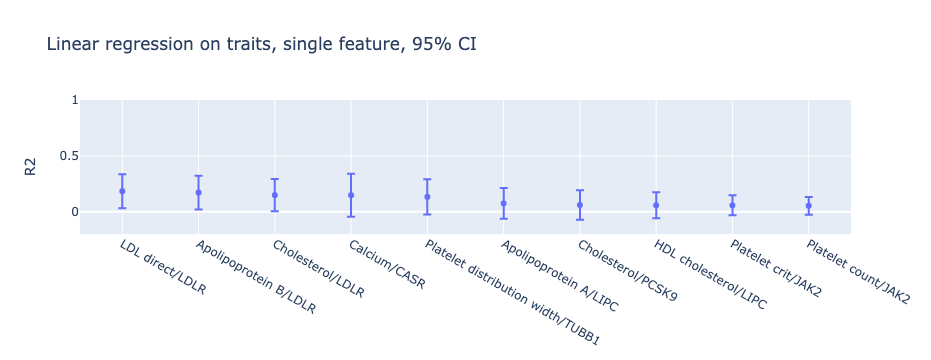

In [189]:
fig = go.Figure(data=go.Scatter(
        x=regression_results_for_plot["phenotype/gene"],
        y=regression_results_for_plot["mean"],
        mode='markers',
        error_y=dict(
            type='data',
            array=regression_results_for_plot["ci"],
            visible=True)
    ), layout=dict(
        title="Linear regression on traits, single feature, 95% CI",
        yaxis_title="R2",
        yaxis_range=[-0.2,1]))
fig.show()

In [187]:
# most common features appear to be the most versatile trait predictors
regression_results_df.groupby("feature").count().sort_values("phenotype/gene", ascending=False)["phenotype/gene"].reset_index().head(10)

,feature,phenotype/gene
0,MetaRNN_rankscore,300
1,Eigen-phred_coding,284
2,VEST4_rankscore,267
3,REVEL_score,266
4,ClinPred_rankscore,263
5,pph2_prob_y,259
6,BayesDel_addAF_score,258
7,pph2_FDR_y,258
8,REVEL_rankscore,258
9,Eigen-PC-phred_coding,257


In [275]:
# generate a single dataframe with these phenotype/gene pairs

all_vars_phenotypes_df = None
for phenotype in regression_results_df.phenotype.unique():
    vars_df = pd.read_pickle(all_adjusted_phenotypes[all_adjusted_phenotypes.phenotype == phenotype].var_phenotype_path.iloc[0])
    vars_df = vars_df[vars_df.gene.isin(regression_results_df[regression_results_df.phenotype == phenotype].gene.unique())]
    vars_df["phenotype"] = phenotype
    phenotype_continuous = all_adjusted_phenotypes[all_adjusted_phenotypes.phenotype == phenotype].type.iloc[0] == "continuous"
    if phenotype_continuous:
        vars_df = vars_df.drop(columns=["mean", "std", "median/phenotype_std", "median/gene_medians_std"]).rename(columns={"median": "predictand"})
    else:
        vars_df = vars_df.drop(columns=["median", "std", "median/phenotype_std", "median/gene_medians_std"]).rename(columns={"mean": "predictand"})
    vars_df["phenotype_continuous"] = phenotype_continuous
    if all_vars_phenotypes_df is None:
        all_vars_phenotypes_df = vars_df
    else:
        all_vars_phenotypes_df = pd.concat((all_vars_phenotypes_df, vars_df), axis=0)
variant_features_all = pd.read_pickle(constants.variant_features_all)
all_vars_phenotypes_df = all_vars_phenotypes_df.merge(variant_features_all[["var_id"] + constants.all_cat_cols \
                                                      + constants.all_cont_cols + list(map(lambda x: x + "_na", constants.all_cont_cols))],
                                                      on="var_id", how="left")
all_vars_phenotypes_df.to_pickle(global_constants.top_regression_vars_phenotypes_path)

## Execute multi feature regression before proceeding

In [ ]:
!python execute_multi_feature_regression.py

In [48]:
multi_feature_regression_results_df = pd.read_pickle("regression_multi_feature.pkl")

multi_feature_regression_results_df = add_ci_filter_mean(multi_feature_regression_results_df)

multi_feature_regression_results_for_plot = pick_top_phenotype_gene_pairs(multi_feature_regression_results_df)

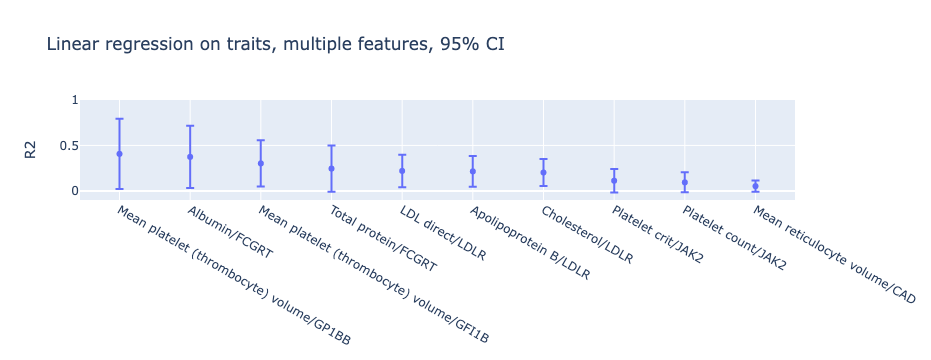

In [51]:
fig = go.Figure(data=go.Scatter(
        x=multi_feature_regression_results_for_plot["phenotype/gene"],
        y=multi_feature_regression_results_for_plot["mean"],
        mode='markers',
        error_y=dict(
            type='data',
            array=multi_feature_regression_results_for_plot["ci"],
            visible=True)
    ), layout=dict(
        title="Linear regression on traits, multiple features, 95% CI",
        yaxis_title="R2",
        yaxis_range=[-0.1,1]))
fig.show()

In [53]:
regression_results_df_for_plot = regression_results_df.sort_values("mean_ci_difference", ascending=False)
regression_results_df_for_plot = regression_results_df_for_plot.drop_duplicates("phenotype/gene")
regression_results_df_for_plot = regression_results_df_for_plot.merge(multi_feature_regression_results_for_plot[["phenotype/gene"]], how="right")

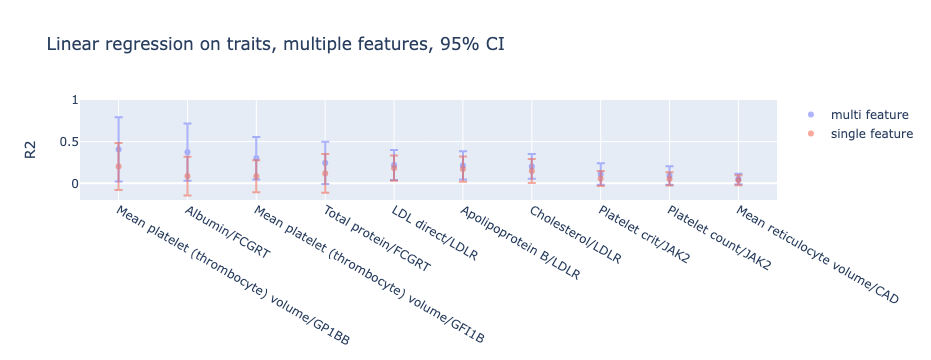

In [188]:
fig = go.Figure(data=[go.Scatter(
        x=multi_feature_regression_results_for_plot["phenotype/gene"],
        y=multi_feature_regression_results_for_plot["mean"],
        mode='markers',
        opacity=.5,
        name="multi feature",
        error_y=dict(
            type='data',
            array=multi_feature_regression_results_for_plot["ci"],
            visible=True)
    ), go.Scatter(
        x=regression_results_df_for_plot["phenotype/gene"],
        y=regression_results_df_for_plot["mean"],
        mode='markers',
        opacity=.5,
        name="single feature",
        error_y=dict(
            type='data',
            array=regression_results_df_for_plot["ci"],
            visible=True))],
    layout=dict(
        title="Linear regression on traits, multiple features, 95% CI",
        yaxis_title="R2",
        yaxis_range=[-0.2,1]))
fig.show()

In [60]:
# see for how many pairs there is improvement in mean, for how many mean ci differences are higher
joint_single_multi = regression_results_df.sort_values("mean", ascending=False).drop_duplicates("phenotype/gene").merge(
    multi_feature_regression_results_df.sort_values("mean", ascending=False).drop_duplicates("phenotype/gene"), on="phenotype/gene", how="left")


In [90]:
print(f"We see higher mean R2 in {len(joint_single_multi[joint_single_multi.mean_x < joint_single_multi.mean_y]) / len(joint_single_multi):.2f}%\
 of phenotype-gene pairs when using multiple features (out of {len(joint_single_multi)} pairs) and in \
{(len(joint_single_multi[joint_single_multi.mean_x - joint_single_multi.std_x < joint_single_multi.mean_y - joint_single_multi.std_y])) / len(joint_single_multi):.2f}%\
 'mean R2 - R2 std dev' difference is higher. Note that standard deviation is also higher in {len(joint_single_multi[joint_single_multi.std_x < joint_single_multi.std_y])/len(joint_single_multi):.2f}%.")


We see higher mean R2 in 0.95% of phenotype-gene pairs when using multiple features (out of 524 pairs) and in 0.70% 'mean R2 - R2 std dev' difference is higher. Note that standard deviation is also higher in 0.82%.


In [ ]:
set(multi_feature_regression_results_df[multi_feature_regression_results_df["mean"] > multi_feature_regression_results_df["std"]].drop_duplicates(
    "phenotype/gene")["phenotype/gene"].unique()).difference(
    regression_results_df[regression_results_df["mean"] > regression_results_df["std"]].drop_duplicates("phenotype/gene")["phenotype/gene"].unique())

In [235]:
# check if there are any phenotype/gene pairs where mean R2 is greater than std and that are better predicted with a single feature
better_single_set = set(regression_results_df[regression_results_df["mean"] > regression_results_df["std"]].drop_duplicates("phenotype/gene")["phenotype/gene"].unique()).difference(
    multi_feature_regression_results_df[multi_feature_regression_results_df["mean"] > multi_feature_regression_results_df["std"]].drop_duplicates(
    "phenotype/gene")["phenotype/gene"].unique())
better_single_set

{'Apolipoprotein A/LIPC'}

In [275]:
phenotype_gene_top_features = multi_feature_regression_results_df[multi_feature_regression_results_df["mean"] > multi_feature_regression_results_df["std"]].sort_values(
    "mean", ascending=False).drop_duplicates("phenotype/gene")

regression_results_df_top = regression_results_df[
    regression_results_df["phenotype/gene"].isin(better_single_set) & (regression_results_df["mean"] > regression_results_df["std"])].sort_values(
    "mean", ascending=False).drop_duplicates("phenotype/gene")

regression_results_df_top.feature = regression_results_df_top.feature.apply(lambda x: [x])
regression_results_df_top = regression_results_df_top.rename(columns={"feature": "features"}).drop(columns="extended_features")

phenotype_gene_top_features = pd.concat((phenotype_gene_top_features, regression_results_df_top), axis=0)
phenotype_gene_top_features.reset_index(drop=True)
# save the df with top features
phenotype_gene_top_features.to_pickle("regression_results_w_multi_features_processed.pkl")

In [281]:
# most often occuring features
phenotype_gene_top_features.features.explode().reset_index().groupby("features").count().sort_values(
    "index", ascending=False).reset_index().rename(columns={"index": "# occurences"}).head(10)

,features,# occurences
0,NormASA,12
1,BayesDel_addAF_pred,9
2,MutPred_rankscore,8
3,dVol_**2,8
4,JXmin,7
5,M-CAP_pred,7
6,ClinPred_pred,7
7,MetaLR_pred,6
8,MetaRNN_rankscore,6
9,trv,6


In [349]:
# try various configurations for MLP training: LDLR to predict LDL, multiple outputs
# same for Platelet distribution width/TUBB1 and Platelet count/JAK2

In [357]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [355]:
import data_helpers

In [385]:
parameters = {'hidden_layer_sizes':((250,)), 'max_iter':[2000],
              "activation":["logistic"]}

In [368]:
phenotype_gene = "LDL direct/LDLR"

In [374]:
phenotype_gene_to_features_mapping = dict(phenotype_gene_top_features[["phenotype/gene", "features"]].values)

train_size = 0.8
n_seeds = 10
phenotype = phenotype_gene.split("/")[0]
gene = phenotype_gene.split("/")[1]
results = []
vars_df = all_vars_phenotypes_df[(all_vars_phenotypes_df.phenotype == phenotype) & (all_vars_phenotypes_df.gene == gene)]
phenotype_continuous = vars_df.phenotype_continuous.iloc[0]
# start with top result feature
top_features = phenotype_gene_to_features_mapping[phenotype_gene]
vars_df = data_helpers.get_features_df(vars_df, phenotype_gene_to_features_mapping[phenotype_gene] + \
                                      phenotype_gene_to_features_mapping["Cholesterol/LDLR"] + phenotype_gene_to_features_mapping["Apolipoprotein B"])
for maf in [0.1]:
    cur_vars_df = vars_df[vars_df.highest_AF < maf]
    cur_unique_vars = cur_vars_df.var_id.unique()
    cur_best_mean_r2 = -99999
    cur_best_median_r2 = 0
    cur_best_std_r2 = 0
    cur_best_features = []
    
    regr = MLPRegressor()
    clf = GridSearchCV(regr, parameters)
    clf.fit(cur_vars_df.values[:, 3:], cur_vars_df.predictand.values)

#     all_r2 = []
#     for seed in range(n_seeds):
#         # split on variants
#         train_variants, test_variants = train_test_split(cur_unique_vars, train_size=train_size, random_state=seed)
#         train_split, test_split = cur_vars_df[cur_vars_df.var_id.isin(train_variants)], cur_vars_df[cur_vars_df.var_id.isin(test_variants)]
#         Xs_train, Xs_test, ys_train, ys_test = train_split.iloc[:, 3:].values, test_split.iloc[:, 3:].values, train_split.predictand, test_split.predictand
#         model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=5000, activation="tanh")
#         regr = model.fit(Xs_train, ys_train)
#         cur_r2 = r2_score(ys_test, regr.predict(Xs_test))
#         all_r2.append(cur_r2)
#     cur_mean_r2 = np.mean(all_r2)
#     cur_best_median_r2 = np.median(all_r2)
#     cur_best_std_r2 = np.std(all_r2)
#     results.append((phenotype_gene, top_features, cur_mean_r2, cur_best_median_r2, cur_best_std_r2, len(cur_vars_df), maf))

In [375]:
clf.best_params_

{'activation': 'logistic', 'hidden_layer_sizes': (250,), 'max_iter': 2000}

In [379]:
clf.score(cur_vars_df.values[:, 3:], cur_vars_df.predictand.values)

0.2424773156378779

In [381]:
phenotype_gene_top_features[phenotype_gene_top_features.gene == "LDLR"]

,phenotype/gene,features,mean,median,std,#variants,maf,phenotype,gene,ci,mean_ci_difference
61,LDL direct/LDLR,"[BayesDel_addAF_rankscore, BayesDel_addAF_rank...",0.219764,0.243628,0.091476,387,0.010,LDL direct,LDLR,0.179289,0.040475
67,Apolipoprotein B/LDLR,"[BayesDel_addAF_score, BayesDel_addAF_score_**...",0.214660,0.217351,0.086466,383,0.010,Apolipoprotein B,LDLR,0.169470,0.045190
81,Cholesterol/LDLR,"[MetaRNN_rankscore, MetaRNN_rankscore_**2, Met...",0.202489,0.209053,0.075768,371,0.001,Cholesterol,LDLR,0.148503,0.053985


In [ ]:
# add another output - LDLR but other out

In [ ]:
second_phenotype_gene = "Cholesterol/LDLR"

In [451]:
phenotype_gene_to_features_mapping = dict(phenotype_gene_top_features[["phenotype/gene", "features"]].values)

train_size = 0.8
n_seeds = 10
phenotype = phenotype_gene.split("/")[0]
gene = phenotype_gene.split("/")[1]
results = []
vars_df = all_vars_phenotypes_df[all_vars_phenotypes_df.phenotype.isin(["Cholesterol", "LDL direct", "Apolipoprotein B"]) & (all_vars_phenotypes_df.gene == gene)]
vars_multi_out = vars_df[["var_id", "phenotype", "predictand"]]
vars_multi_out = vars_multi_out.groupby("var_id").predictand.apply(list).reset_index()
vars_multi_out = vars_multi_out[vars_multi_out.predictand.apply(len) == 3]
# start with top result feature
top_features = phenotype_gene_to_features_mapping["Cholesterol/LDLR"]#phenotype_gene_to_features_mapping[phenotype_gene] + \
                                       #+ phenotype_gene_to_features_mapping["Apolipoprotein B/LDLR"]
vars_df = data_helpers.get_features_df(vars_df[vars_df.phenotype == "LDL direct"], top_features)
maf = 0.1
cur_vars_df = vars_df[vars_df.highest_AF < maf]
cur_vars_df = cur_vars_df.merge(vars_multi_out, how="inner", on="var_id")
cur_unique_vars = cur_vars_df.var_id.unique()
cur_best_mean_r2 = -99999
cur_best_median_r2 = 0
cur_best_std_r2 = 0
cur_best_features = []

all_r2 = []
for seed in range(n_seeds):
    # split on variants
    train_variants, test_variants = train_test_split(cur_unique_vars, train_size=train_size, random_state=seed)
    train_split, test_split = cur_vars_df[cur_vars_df.var_id.isin(train_variants)], cur_vars_df[cur_vars_df.var_id.isin(test_variants)]
    Xs_train, Xs_test, ys_train, ys_test = train_split.iloc[:, 3:-1].values, test_split.iloc[:, 3:-1].values, np.array(train_split.predictand_y.values.tolist()), np.array(test_split.predictand_y.values.tolist())
    # for categorical phenotypes use logit regression
    model = MLPRegressor(hidden_layer_sizes=(250,), max_iter=2000, activation="logistic")#LinearRegression() if phenotype_continuous else LogitRegression()
    regr = model.fit(Xs_train, ys_train)
    cur_r2 = r2_score(ys_test[:,1], regr.predict(Xs_test)[:, 1])
    all_r2.append(cur_r2)
print(f"mean: {np.mean(all_r2)}")
print(f"median: {np.median(all_r2)}")
print(f"std: {np.std(all_r2)}")

regr = MLPRegressor(hidden_layer_sizes=(250,), max_iter=2000,
              activation="logistic")
clf.fit(cur_vars_df.values[:, 3:-1], np.array(cur_vars_df.predictand_y.values.tolist()))

mean: -0.0005952919567927095
median: 0.047712635591234176
std: 0.14726580413968446


GridSearchCV(estimator=MLPRegressor(),
             param_grid={'activation': ['logistic'],
                         'hidden_layer_sizes': (250,), 'max_iter': [2000]})

In [ ]:
# zero, 3 outs
# mean: 0.1847373429030412
# median: 0.21774385378285283
# std: 0.1068405856640215

# zero 1 out
# mean: 0.18018659409865082
# median: 0.20942958166422626
# std: 0.11547843140092721

In [ ]:
# one, 3 outs
# mean: 0.19007749050054612
# median: 0.21101389118442676
# std: 0.11206605086316353

# one, 1 out
# mean: 0.14246608201244024
# median: 0.1539996656925416
# std: 0.08787060432377644

In [ ]:
# two 3 outs
# mean: 0.1305830545883707
# median: 0.1522987318450354
# std: 0.10818831707308864

# two one out
# mean: 0.13165787106368576
# median: 0.16081015771324608
# std: 0.11927673626933531

In [429]:
# "zero":
# mean: 0.20150328062109762
# median: 0.18861235736529725
# std: 0.051496798165414276

In [ ]:
# "one":
# mean: 0.178338184617977
# median: 0.1709843692565387
# std: 0.04217340423498233

In [159]:
# run regression on these features, but normalize the predictand - subtract mean, divide by std dev.
# this is to have one model to treat multiple genes/traits. Normalize per gene/trait pair.
!python execute_regression_normalized_data.py

In [ ]:
add_ci_filter_mean(pd.read_pickle("regression_multi_feature_normalized.pkl")).sort_values("mean_ci_difference", ascending=False).drop_duplicates("phenotype/gene").head(10)

In [475]:
add_ci_filter_mean(pd.read_pickle("regression_multi_feature_normalized.pkl")).sort_values("mean_ci_difference", ascending=False).drop_duplicates("phenotype/gene").head(10)

,phenotype/gene,features,mean,median,std,#variants,maf,phenotype,gene,ci,mean_ci_difference
16,Calcium/CASR,"[EVE_scores_ASM, EVE_scores_ASM_na, site, phyl...",0.158051,0.159185,0.025800,309,0.0100,Calcium,CASR,0.050567,0.107484
13,Immature reticulocyte fraction/GMPR,"[polar_delta, polar_delta_**2, trv, dVol_**2, ...",0.165158,0.150898,0.041324,108,0.0001,Immature reticulocyte fraction,GMPR,0.080994,0.084164
5,Apolipoprotein A/NEK7,"[phastCons17way_primate, phastCons17way_primat...",0.196919,0.192690,0.064679,77,0.0010,Apolipoprotein A,NEK7,0.126768,0.070151
11,LDL direct/LDLR,"[BayesDel_addAF_rankscore, BayesDel_addAF_rank...",0.169094,0.172389,0.051474,389,0.1000,LDL direct,LDLR,0.100886,0.068207
31,Phosphate/ALPL,"[BayesDel_noAF_score, JXc, BayesDel_addAF_pred...",0.125282,0.126893,0.039267,213,0.0010,Phosphate,ALPL,0.076961,0.048321
9,Cholesterol/LDLR,"[MetaRNN_rankscore, MetaRNN_rankscore_**2, Met...",0.169660,0.167156,0.063613,371,0.0010,Cholesterol,LDLR,0.124679,0.044981
25,Apolipoprotein B/LDLR,"[BayesDel_addAF_score, BayesDel_addAF_score_**...",0.142124,0.126225,0.055314,385,0.1000,Apolipoprotein B,LDLR,0.108413,0.033711
12,Platelet distribution width/TUBB1,"[VEST4_rankscore, VEST4_rankscore_**2, predict...",0.168485,0.140036,0.084614,212,0.0010,Platelet distribution width,TUBB1,0.165840,0.002645
18,Mean platelet (thrombocyte) volume/GFI1B,"[NormASA, prediction, SecStr, MapReg, MetaLR_p...",0.155434,0.139781,0.080662,187,0.1000,Mean platelet (thrombocyte) volume,GFI1B,0.158094,-0.002660
91,Mean reticulocyte volume/CAD,"[Eigen-phred_coding, dScore, pph2_TPR_y]",0.040002,0.043313,0.022532,794,0.1000,Mean reticulocyte volume,CAD,0.044162,-0.004161


In [478]:
add_ci_filter_mean(pd.read_pickle("regression_multi_feature_normalized.pkl")).sort_values("mean_ci_difference", ascending=False).drop_duplicates("phenotype/gene").head(10)

,phenotype/gene,features,mean,median,std,#variants,maf,phenotype,gene,ci,mean_ci_difference
23,Calcium/CASR,"[EVE_scores_ASM, EVE_scores_ASM_na, site, phyl...",0.140190,0.137172,0.028232,309,0.0100,Calcium,CASR,0.055334,0.084856
11,LDL direct/LDLR,"[BayesDel_addAF_rankscore, BayesDel_addAF_rank...",0.173552,0.181602,0.056552,389,0.1000,LDL direct,LDLR,0.110841,0.062711
19,Apolipoprotein B/LDLR,"[BayesDel_addAF_score, BayesDel_addAF_score_**...",0.151691,0.146632,0.046881,385,0.1000,Apolipoprotein B,LDLR,0.091885,0.059805
13,Cholesterol/LDLR,"[MetaRNN_rankscore, MetaRNN_rankscore_**2, Met...",0.165898,0.154146,0.057607,371,0.0010,Cholesterol,LDLR,0.112908,0.052990
16,Platelet distribution width/TUBB1,"[VEST4_rankscore, VEST4_rankscore_**2, predict...",0.158853,0.156984,0.058932,212,0.0010,Platelet distribution width,TUBB1,0.115505,0.043348
36,Phosphate/ALPL,"[BayesDel_noAF_score, JXc, BayesDel_addAF_pred...",0.100641,0.105879,0.032495,220,0.1000,Phosphate,ALPL,0.063690,0.036952
9,Mean platelet (thrombocyte) volume/GFI1B,"[NormASA, prediction, SecStr, MapReg, MetaLR_p...",0.174904,0.155708,0.075415,187,0.1000,Mean platelet (thrombocyte) volume,GFI1B,0.147811,0.027094
64,Platelet crit/JAK2,"[VARITY_ER, VARITY_ER_**2, dgn, Nvars_**2, IdQ...",0.055770,0.057403,0.025594,483,0.1000,Platelet crit,JAK2,0.050164,0.005606
57,Platelet count/JAK2,"[VEST4_rankscore, VEST4_rankscore_**2, EVE_sco...",0.064091,0.065249,0.035128,468,0.0010,Platelet count,JAK2,0.068849,-0.004758
25,Immature reticulocyte fraction/GMPR,"[polar_delta, polar_delta_**2, trv, dVol_**2, ...",0.135646,0.119214,0.071794,108,0.0001,Immature reticulocyte fraction,GMPR,0.140714,-0.005068


In [263]:
# run regression after normalization on all the pairs, either using one set of features, the other, both to predict both.

In [346]:
phenotype_gene_top_features.sort_values("mean_ci_difference", ascending=False).head(10)

,phenotype/gene,features,mean,median,std,#variants,maf,phenotype,gene,ci,mean_ci_difference
81,Cholesterol/LDLR,"[MetaRNN_rankscore, MetaRNN_rankscore_**2, Met...",0.202489,0.209053,0.075768,371,0.0010,Cholesterol,LDLR,0.148503,0.053985
67,Apolipoprotein B/LDLR,"[BayesDel_addAF_score, BayesDel_addAF_score_**...",0.214660,0.217351,0.086466,383,0.0100,Apolipoprotein B,LDLR,0.169470,0.045190
61,LDL direct/LDLR,"[BayesDel_addAF_rankscore, BayesDel_addAF_rank...",0.219764,0.243628,0.091476,387,0.0100,LDL direct,LDLR,0.179289,0.040475
5,Mean platelet (thrombocyte) volume/GP1BB,"[MetaRNN_rankscore, MetaRNN_rankscore_**2, Met...",0.407109,0.425871,0.196747,103,0.0010,Mean platelet (thrombocyte) volume,GP1BB,0.385617,0.021492
1,Albumin/FCGRT,"[BayesDel_noAF_score, CpG, BayesDel_addAF_pred...",0.470391,0.539265,0.236761,116,0.0001,Albumin,FCGRT,0.464042,0.006349
777,Mean reticulocyte volume/CAD,"[Eigen-phred_coding, dScore, pph2_TPR_y]",0.051864,0.055850,0.031601,794,0.1000,Mean reticulocyte volume,CAD,0.061938,-0.010073
307,Platelet crit/JAK2,"[VARITY_ER, VARITY_ER_**2, dgn, Nvars_**2, IdQ...",0.112229,0.108302,0.066049,378,0.0001,Platelet crit,JAK2,0.129453,-0.017224
36,Body fat percentage/PPARG,"[ClinPred_rankscore, ClinPred_pred, PrimateAI_...",0.255604,0.252169,0.141371,136,0.0100,Body fat percentage,PPARG,0.277083,-0.021479
225,Apolipoprotein B/PCSK9,"[VARITY_ER, Nsubs_log, EVE_scores_ASM_**2, GER...",0.134450,0.137978,0.089024,279,0.1000,Apolipoprotein B,PCSK9,0.174483,-0.040033
381,Platelet count/JAK2,"[VEST4_rankscore, VEST4_rankscore_**2, EVE_sco...",0.098177,0.103849,0.072486,378,0.0001,Platelet count,JAK2,0.142069,-0.043892


In [ ]:
# do just LDLR, but try to add other phenotypes to see whether this will improve MLP